# Explore E3SM Co2 timestepbudget

In previous analysis, there was a small discrepancy between changes in total column-integrated CO2 mass and the time-integrated emission fluxes. To determine what is causing the discrepancy, we want to see if it is still there when we look at individual timesteps.


#### Data sources

**Model**: e3sm test_co2 run for 5 days with precipitation output for checking the budget
* runscript (`test_co2_hist_files_ne4pg2_longbudget.sh`), with options  
    ○ casename=test_co2_hist_files_ne4pg2_timestepbudget  
    ○ --compset FC5AV1C-04P2  
    ○ --res ne4pg2_ne4pg2  
    ○ CAM_CONFIG_OPTS="-co2_cycle"  
    ○ RUN_STARTDATE=1950-01-01  
    ○ STOP_N=5  
    ○ RESUBMIT=0  
    ○ STOP_OPTION=ndays
* namelist options:  
    ○ nhtfrq = 1  
* History files concatenated using `ncrcat -h -v`  

#### Changes

- 2020 September: Created  

#### Style notes

<br>
<i>Note these header symbols for marking status:</i>
<li> 🟩 means section is still in progress </li>
<li> ✅ means section has been completed </li>
<br>
<i>Note these naming conventions:</i>
<li> <code>arr_</code> means a numpy array </li>
<li> <code>ds_</code> means an xArray DataSet </li>
<li> <code>da_</code> means a xArray DataArray </li>
<li> <code>df_</code> means a pandas DataFrame </li>

## Setup

In [1]:
import os
from textwrap import wrap

In [2]:
import datetime as dt
from datetime import date

today = date.today()

In [3]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

In [4]:
import matplotlib
from matplotlib import cm
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

***Set up plotting fonts and use latex formatting***

In [5]:
# rc('text', usetex=True)# use latex for font rendering
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})
matplotlib.rcParams.update({'font.size': 18})

In [6]:
import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

## Data import

In [7]:
datadir  = '/global/homes/d/dekauf/e3sm_output/'
nat_file = 'test_co2_hist_files_ne4pg2_timestepbudget_record.CO2.nc'
# rgr_file = 'test_co2_hist_files_take3_rgr_cmip6_180x360_record.CO2.nc'

In [8]:
ds = xr.open_dataset(datadir + nat_file, decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (ilev: 73, lev: 72, nbnd: 2, ncol: 384, time: 121)
Coordinates:
  * lev        (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
  * ilev       (ilev) float64 0.1 0.1477 0.218 0.3219 ... 990.5 997.0 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 4.917 4.958 5.0
Dimensions without coordinates: nbnd, ncol
Data variables:
    lat        (ncol) float64 ...
    lon        (ncol) float64 ...
    area_p     (ncol) float64 ...
    hyam       (lev) float64 ...
    hybm       (lev) float64 ...
    P0         float64 ...
    hyai       (ilev) float64 ...
    hybi       (ilev) float64 ...
    time_bnds  (time, nbnd) float64 ...
    AFCO2      (time, lev, ncol) float64 ...
    BC01Q      (time, ncol) float64 ...
    BC01TW     (time, ncol) float64 ...
    BC02Q      (time, ncol) float64 ...
    BC02TW     (time, ncol) float64 ...
    CO2        (time, lev, ncol) float64 ...
    PRECT      (time, ncol) float64 ...
    PS         (time, ncol) float64 ...
    QFLX       (time, ncol) float64 ...
    SFCO2      (time, ncol) float64 ...
    SFCO2_FFF  (time, ncol) float64 ...
    SFCO2_LND  (time, ncol) float64 ...
    SFCO2_OCN  (time, ncol) float64 ...
    T          (time, lev, ncol) float64 ...
    TAFCO2     (time, ncol) float64 ...
    TMCO2      (time, ncol) float64 ...
    TMCO2_FFF  (time, ncol) float64 ...
    TMCO2_LND  (time, ncol) float64 ...
    TMCO2_OCN  (time, ncol) float64 ...
    TMQ        (time, ncol) float64 ...
    TS         (time, ncol) float64 ...
Attributes:
    ne:                4
    fv_nphys:          2
    Conventions:       CF-1.0
    source:            CAM
    case:              test_co2_hist_files_ne4pg2_timestepbudget
    title:             UNSET
    logname:           kauf418
    host:              
    Version:           $Name$
    revision_Id:       $Id$
    initial_file:      /compyfs/inputdata/atm/cam/inic/homme/cami_mam3_Linoz_...
    topography_file:   /compyfs/inputdata/atm/cam/topo/USGS-gtopo30_ne4pg2_16...
    time_period_freq:  hour_1

In [9]:
ds['BC02TW']

<xarray.DataArray 'BC02TW' (time: 121, ncol: 384)>
array([[28.723357, 25.586547, 37.038721, ...,  0.964149,  3.808877,  4.204165],
       [28.886332, 25.602919, 37.019587, ...,  0.916074,  3.640044,  4.026364],
       [29.191088, 25.72026 , 37.022711, ...,  0.915058,  3.630276,  4.04957 ],
       ...,
       [27.373749, 25.207843, 42.921392, ...,  2.265642,  2.142533,  6.830741],
       [27.184761, 25.113155, 42.760824, ...,  2.252371,  2.116158,  6.828398],
       [27.0293  , 25.034935, 42.606719, ...,  2.246404,  2.123067,  6.850099]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 4.875 4.917 4.958 5.0
Dimensions without coordinates: ncol
Attributes:
    units:      kg/m2
    long_name:  total water after process

## Wrangling

##### Convert E3SM $CO_2$ $kg/kg$ to $ppm$

\begin{array}{lllll}
      & CO_2\,molar\,mass & \times dry-air\,molar\,mass & \times ppm \\
    ppmfac = & \frac{1\,kmol_{CO_2}}{44.01\,kg_{CO_2}} & \times \frac{28.9647\,kg_{air}}{1\,kmol_{air}} & \times \frac{1e6\,mol_{air}}{1\,mol_{CO_2}}
\end{array}

\begin{align}
    CO_2\,dry\,air\,mass\,fraction\,(i.e. \frac{kg_{CO_2}}{kg_{air}}) \times ppmfac & = ppm \\
\end{align}

In [10]:
mwco2 = 44.01
mwdry  = 28.9647
mwfac  = mwdry / mwco2
ppmfac = mwfac * 1e6

In [11]:
temp_long_name = ds['CO2'].long_name

# do the conversion
ds['CO2'] = ds['CO2']*ppmfac
ds['CO2'].attrs["units"] = 'ppm'
ds['CO2'].attrs['long_name'] = temp_long_name

print(f"min: {ds['CO2'].min().values.item()}")
print(f"mean: {ds['CO2'].mean().values.item()}")
print(f"max: {ds['CO2'].max().values.item()}")
print(f"shape: {ds['CO2'].mean(dim='lev').shape}")

min: 366.6763371607383
mean: 369.5015550359418
max: 376.09228368368804
shape: (121, 384)


### Global means with weighting by area

xarray has recently introduced a weighting method (http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html).  The area of each grid cell for the ne4pg2/ne30pg2 grids is called “area_p”.  For the ne4/ne30 grids it is just called “area”.  Not sure why they changed it.

**Global means** (`glmean_...`) are

\begin{align*}
    && \texttt{glmean_CO2var}_{t}= & \frac{\sum_{i=1}^{nlat}\sum_{j=1}^{nlon} \texttt{CO2var}_{i,j,t} * \texttt{area}_{i,j}}{\sum_{i=1}^{nlat}\sum_{j=1}^{nlon} \texttt{area}_{i,j}}     &&\forall t, \\
    with\,units: && \{kg/m^2\}_t= & \frac{\sum_{i=1}^{nlat}\sum_{j=1}^{nlon} \{kg/{m^2}\}_{i,j,t} * \{m^2/m^2\}_{i,j}}{\sum_{i=1}^{nlat}\sum_{j=1}^{nlon} \{m^2/m^2\}_{i,j}}     &&\forall t. \\
\end{align*}

*notes:*
- we would need to multiply by the radius of Earth ($R^2_{E}$ in units of $\{m^2\}$) to get to $kg$ because `area` is in steradians rather than $m^2$.
- the above multiplication by `area` ($m^2/m^2$) is taken care of in the xarray.DataArray.weighted() method.

In [12]:
# Constants are declared.
r_earth = 6.37122e6  # value from the Common Infrastructure for Modeling the Earth (CIME)
surface_area_earth = 4*np.pi*r_earth**2

In [13]:
var_list = ['CO2', 'AFCO2', 'TAFCO2',
 'SFCO2', 'SFCO2_FFF', 'SFCO2_LND', 'SFCO2_OCN',
 'TMCO2', 'TMCO2_FFF', 'TMCO2_LND', 'TMCO2_OCN',
 'TMQ', 'QFLX', 'PRECT']
for var in var_list:
    ds['glmean_' + var] = ds[var].weighted(ds['area_p']).mean(('ncol'))

##### Mean global CO2 mass (`glmean_TMCO2...`)

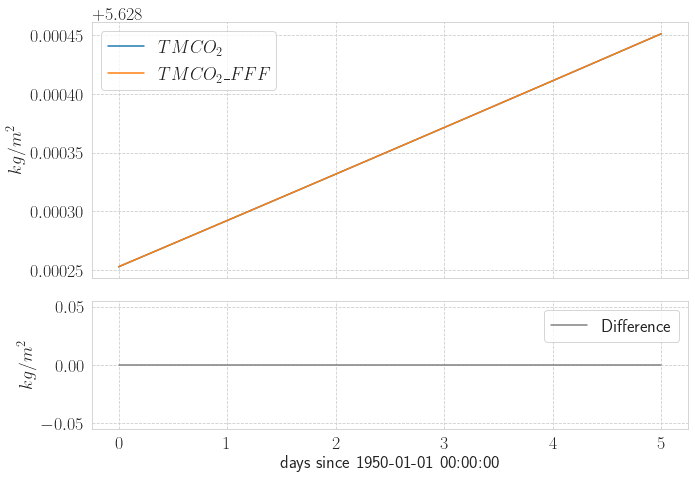

In [14]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'], ds['glmean_TMCO2'], '-', label='$TMCO_2$')
axs[0].plot(ds['time'], ds['glmean_TMCO2_FFF'], label='$TMCO_2\_FFF$')
axs[0].set_ylabel(f"$kg/m^2$")
axs[0].legend()

axs[1].plot(ds['time'], ds['glmean_TMCO2'] - ds['glmean_TMCO2_FFF'], '-', color='gray', label='Difference')
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2$")
axs[1].legend()

plt.tight_layout()
plt.show()

##### Mean global CO2 surface flux(`glmean_SFCO2...`)

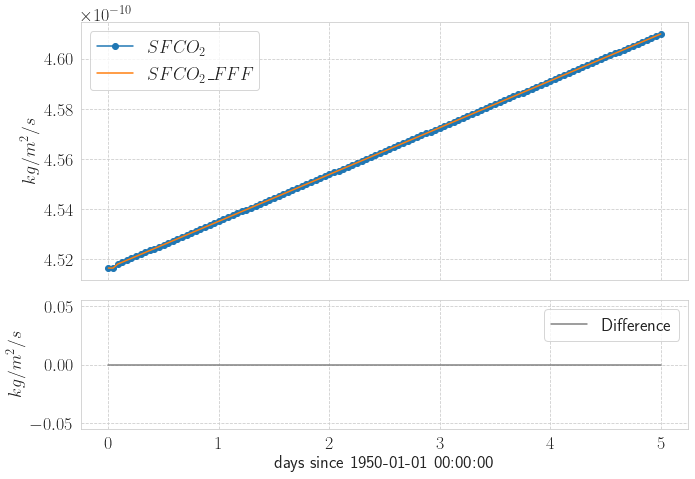

In [15]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'], ds['glmean_SFCO2'], '-o', label='$SFCO_2$')
axs[0].plot(ds['time'], ds['glmean_SFCO2_FFF'], label='$SFCO_2\_FFF$')
axs[0].set_ylabel(f"$kg/m^2/s$")
axs[0].legend()

axs[1].plot(ds['time'], ds['glmean_SFCO2']-ds['glmean_SFCO2_FFF'], color='gray', label='Difference')
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2/s$")
axs[1].legend()

plt.tight_layout()
plt.show()

### ✅ $\Delta{mass_{CO_2}}$ - change in mass of $CO_2$ from timestep to timestep

\begin{align*}
    && \Delta \texttt{glmean_TMCO2}_{t} = \texttt{glmean_TMCO2}_{t} - \texttt{glmean_TMCO2}_{t-1} && \forall t
\end{align*}

note: using TMCO2_FFF instead of TMCO2 because it is instantaneous value at end of month instead of a monthly mean

<span style="color:blue">note from Bryce: </span>
*When the output is specified to be written as instantaneous, then the value is equal to whatever the model value is when the output is written.  For monthly output, that would be at the end of the month.  Since SFCO2 = SFCO2_FFF (because the land and ocean fluxes are zero), then TMCO2 should be equal to TMCO2_FFF.  However, since TMCO2 is written out as a monthly average while TMCO2_FFF is equal to the value of TMCO2_FFF at the end of the month, they will differ some.  The change in TMCO2_FFF from the end of one month to the end of the next month should be exactly equal to the time-integrated fluxes of SFCO2_FFF over the course of that month (technically equal up to the numerical precision of the output data).*

In [16]:
arr_delta_tmco2 = np.insert(np.diff(ds['glmean_TMCO2_FFF']), 0, 0)  # backward difference

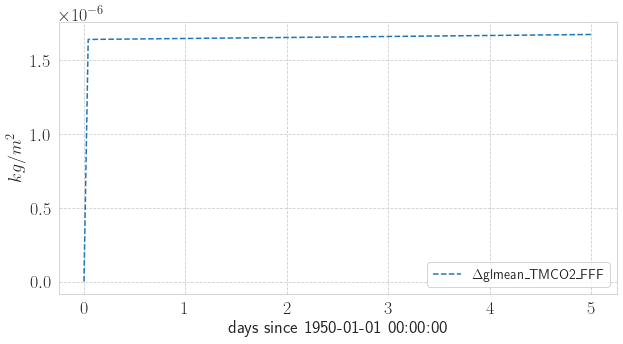

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(ds['time'][0:13], arr_delta_tmco2[0:13], '-o', 
#          label="$\Delta$" + tex_escape('glmean_TMCO2_FFF') + " (first year)")
ax.plot(ds['time'], arr_delta_tmco2, '--', 
         label="$\Delta$" + tex_escape('glmean_TMCO2_FFF'))
#
ax.set_xlabel(f"{ds['time'].attrs['units']}")
ax.set_ylabel(f"$kg/m^2$")
ax.legend(fontsize=14)
#
plt.show()

### ✅ $\int{flux_{CO_2}}$ - time-integrated flux of $CO_2$ from surface emissions and aircraft

\begin{align*}
    && \int_{t-1}^{t} \texttt{SFCO2} \approx & \texttt{glmean_SFCO2}_{t} & * & \quad (time_t - time_{t-1})    &&\forall t, \\
    with\,units: && \{kg/m^2\}_t= & \{kg/m^2/s\}_t& * & \quad \{s\}_{t}    &&\forall t. \\
\end{align*}


Time differences

In [18]:
seconds_per_day = 24 * 60 * 60

In [43]:
dtime_in_seconds = ds['time_bnds'].diff('nbnd') * seconds_per_day

print(dtime_in_seconds.isel(nbnd=0))
print(dtime_in_seconds.astype('int').isel(nbnd=0))
print(dtime_in_seconds.astype('float').isel(nbnd=0))

<xarray.DataArray 'time_bnds' (time: 121)>
array([   0., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600.])
Coordinates

In [44]:
dtime = (ds['time_bnds'].diff('nbnd') * seconds_per_day).astype('float').isel(nbnd=0)
print(dtime)

<xarray.DataArray 'time_bnds' (time: 121)>
array([   0., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
       3600., 3600., 3600., 3600.])
Coordinates

In [45]:
#
arr_int_sfco2 = ds['glmean_SFCO2'] * dtime
#
arr_int_aircraftco2 = ds['glmean_TAFCO2'] * dtime
#
arr_int_totalemissionsflux = arr_int_sfco2 + arr_int_aircraftco2

Here is the difference between including and not including the aircraft fluxes...

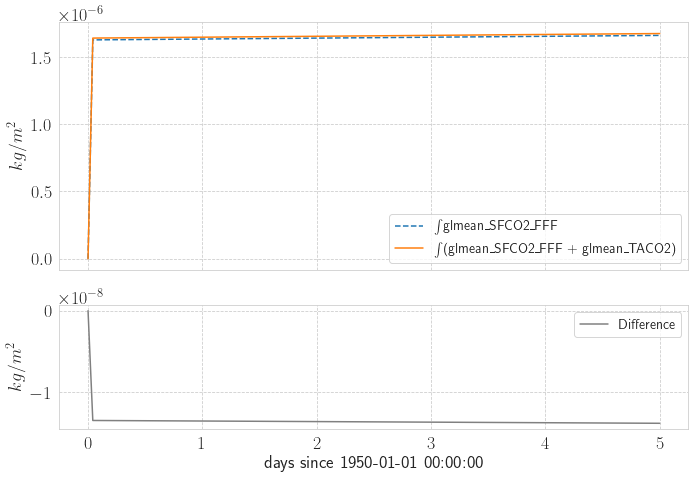

In [46]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'], arr_int_sfco2, '--', 
            label="$\int$" + tex_escape('glmean_SFCO2_FFF'))
axs[0].plot(ds['time'], arr_int_totalemissionsflux, '-',
            label="$\int$" + tex_escape('(glmean_SFCO2_FFF + glmean_TACO2)'))
axs[0].set_ylabel(f"$kg/m^2$")
axs[0].legend(fontsize=14)

axs[1].plot(ds['time'], arr_int_sfco2-arr_int_totalemissionsflux, color='gray', label='Difference')
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2$")
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

## ✅ Comparing $\Delta{mass_{CO_2}}$ with $\int{flux_{CO_2}}$

First dozen times:

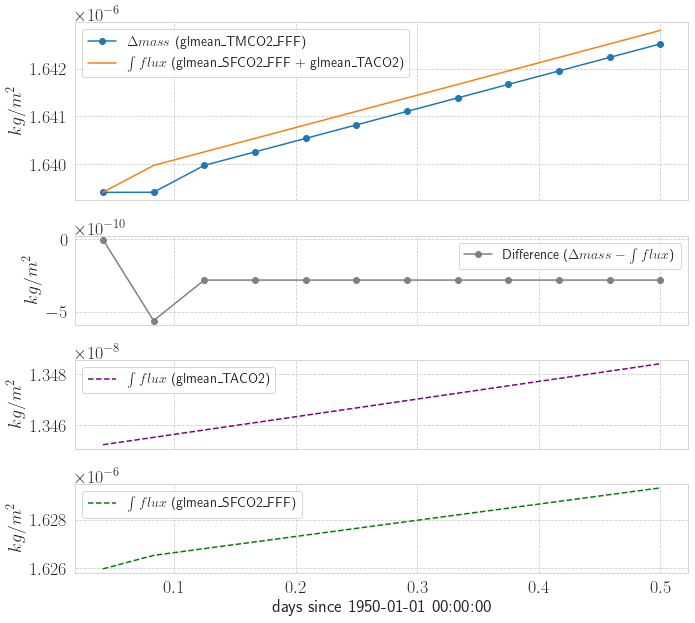

In [47]:
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(10, 9), gridspec_kw={'height_ratios': [2, 1, 1, 1]})

axs[0].plot(ds['time'][1:13], arr_delta_tmco2[1:13], '-o', 
         label="$\Delta mass$" + tex_escape(' (glmean_TMCO2_FFF)'))
axs[0].plot(ds['time'][1:13], arr_int_totalemissionsflux[1:13], '-', 
         label="$\int flux$" + tex_escape(' (glmean_SFCO2_FFF + glmean_TACO2)'))
axs[0].set_ylabel(f"$kg/m^2$")
axs[0].legend(fontsize=14)

axs[1].plot(ds['time'][1:13], arr_delta_tmco2[1:13] - arr_int_totalemissionsflux[1:13], '-o', color='gray', 
         label="Difference ($\Delta mass - \int flux$)")
axs[1].set_ylabel(f"$kg/m^2$")
axs[1].legend(fontsize=14)

axs[2].plot(ds['time'][1:13], arr_int_aircraftco2[1:13], '--', color='purple', 
         label="$\int flux$" + tex_escape(' (glmean_TACO2)'))
axs[2].set_ylabel(f"$kg/m^2$")
axs[2].legend(fontsize=14)

axs[3].plot(ds['time'][1:13], arr_int_sfco2[1:13], '--', color='green',
        label="$\int flux$" + tex_escape(' (glmean_SFCO2_FFF)'))
axs[3].set_ylabel(f"$kg/m^2$")
axs[3].legend(fontsize=14)
axs[3].set_xlabel(f"{ds['time'].attrs['units']}")

plt.tight_layout()
plt.show()

All times:

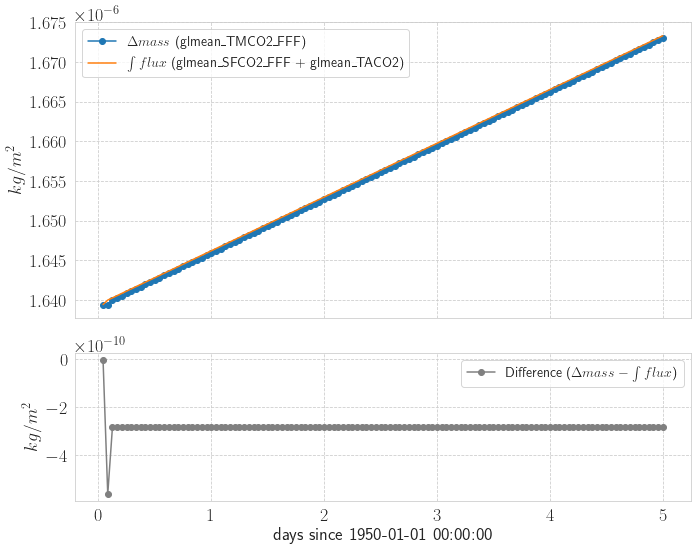

In [48]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'][1:], arr_delta_tmco2[1:], '-o', 
         label="$\Delta mass$" + tex_escape(' (glmean_TMCO2_FFF)'))
axs[0].plot(ds['time'][1:], arr_int_totalemissionsflux[1:], '-', 
         label="$\int flux$" + tex_escape(' (glmean_SFCO2_FFF + glmean_TACO2)'))
axs[0].set_ylabel(f"$kg/m^2$")
axs[0].legend(fontsize=14)

axs[1].plot(ds['time'][1:], arr_delta_tmco2[1:] - arr_int_totalemissionsflux[1:], '-o', color='gray', 
         label="Difference ($\Delta mass - \int flux$)")
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2$")
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

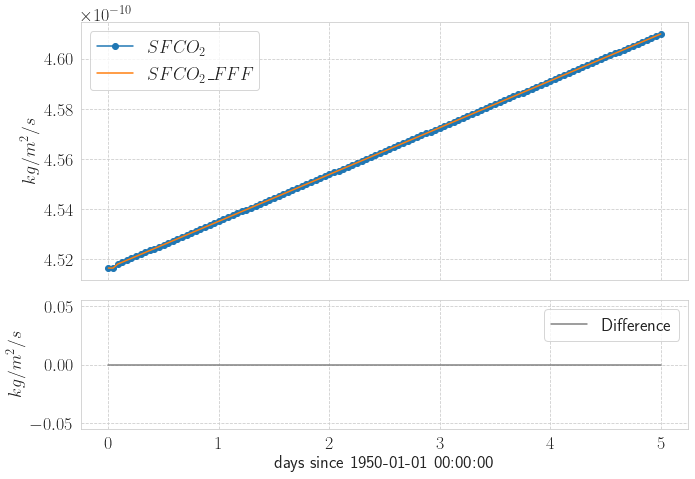

In [49]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'], ds['glmean_SFCO2'], '-o', label='$SFCO_2$')
axs[0].plot(ds['time'], ds['glmean_SFCO2_FFF'], label='$SFCO_2\_FFF$')
axs[0].set_ylabel(f"$kg/m^2/s$")
axs[0].legend()

axs[1].plot(ds['time'], ds['glmean_SFCO2']-ds['glmean_SFCO2_FFF'], color='gray', label='Difference')
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2/s$")
axs[1].legend()

plt.tight_layout()
plt.show()

In [50]:
tempa   = ((ds['glmean_SFCO2'] + ds['glmean_TAFCO2']) * dtime).isel(time=slice(1,13))
tempb   = ds['glmean_TMCO2_FFF'].diff('time').isel(time=slice(1,13))
tot_err_nat = tempb - tempa
rel_err_nat = (tempb - tempa) / tempb

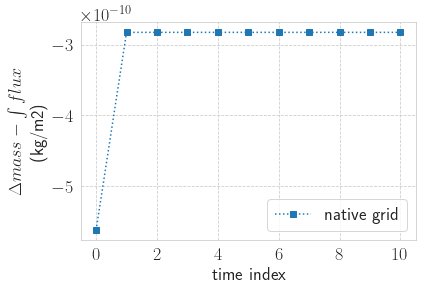

In [51]:
plt.plot(tot_err_nat, ':s', label="native grid")
plt.xlabel("time index")
plt.ylabel("$\Delta mass - \int flux$\n(kg/m2)")
plt.legend()
plt.show()


If we can get the change in precipitable water (TMQ) to match the surface fluxes (QFLX – PRECT) better than we can get TMCO2_FFF changes to match SFCO2_FFF + TAFCO2, then that will suggest there may be a bug we need to look into

### 🟩 $\Delta{mass_{water}}$ - change in total precipitable water from month to month

\begin{align*}
    && \Delta \texttt{glmean_TMQ}_{t}= & \texttt{glmean_TMQ}_{t} & - & \texttt{glmean_TMQ}_{t-1} && \forall t \\
    with\,units: && \{kg/m^2\}_t= & \{kg/m^2\}_t & - & \{kg/m^2\}_{t-1} && \forall t. \\
\end{align*}

In [52]:
arr_delta_TMQ = np.insert(np.diff(ds['glmean_TMQ']), 0, 0)  # backward difference

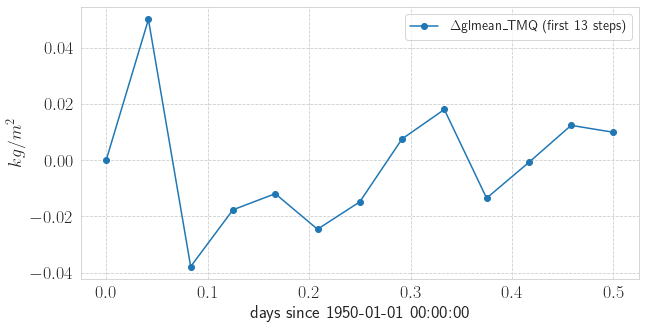

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ds['time'][0:13], arr_delta_TMQ[0:13], '-o', 
         label="$\Delta$" + tex_escape('glmean_TMQ') + " (first 13 steps)")
# ax.plot(ds['time'], arr_delta_TMQ, '--', 
#          label="$\Delta$" + tex_escape('glmean_TMQ'))
#
ax.set_xlabel(f"{ds['time'].attrs['units']}")
ax.set_ylabel(f"$kg/m^2$")
ax.legend(fontsize=14)
#
plt.show()

### 🟩 $\int{flux_{water}}$ - time-integrated flux from surface water flux, `QFLX`, and Total (convective and large-scale) precipitation rate (liq + ice), `PRECT`

\begin{align*}
    && \int_{t-1}^{t} \texttt{QFLX} \approx & \texttt{glmean_QFLX}_{t} & * & \quad (time_t - time_{t-1})    &&\forall t, \\
    with\,units: && \{kg/m^2\}_t= & \{kg/m^2/s\}_t& * & \quad \{s\}_{t}    &&\forall t. \\
    \\
    && \int_{t-1}^{t} \texttt{PRECT} \approx & \texttt{glmean_PRECT}_{t} & * & \quad (time_t - time_{t-1})    &&\forall t, \\
    with\,units: && \{m\}_t= & \{m/s\}_t& * & \quad \{s\}_{t}    &&\forall t. \\
\end{align*}

<br>
Then convert $\texttt{PRECT}$ to flux...
\begin{align*}
    \int_{t-1}^{t} \texttt{PRECT}= & \int_{t-1}^{t} \texttt{PRECT} & * & \text{density of water}    &&\forall t, \\
    \{kg/m^2\}_t= &\{m\}_t & * & \{kg/m^3\}    &&\forall t. \\
\end{align*}

In [53]:
#
arr_int_qflx = ds['glmean_QFLX'] * dtime
#
arr_int_prect = -ds['glmean_PRECT'] * dtime * 1000  # density of water in kg/m3
#
arr_int_totalwaterflux = arr_int_qflx + arr_int_prect

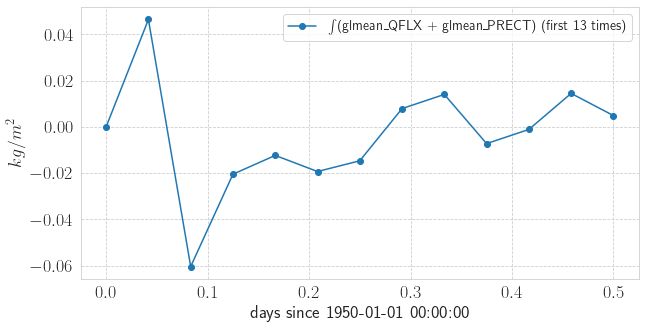

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ds['time'][0:13], arr_int_totalwaterflux[0:13], '-o', 
            label="$\int$" + tex_escape('(glmean_QFLX + glmean_PRECT)') + " (first 13 times)")
# ax.plot(ds['time'], arr_int_totalwaterflux, '--', 
#             label="$\int$" + tex_escape('(glmean_QFLX + glmean_PRECT)'))
#
ax.set_xlabel(f"{ds['time'].attrs['units']}")
ax.set_ylabel(f"$kg/m^2$")
ax.legend(fontsize=14)
#
plt.show()

## 🟩 Comparing $\Delta{mass_{water}}$ with $\int{flux_{water}}$

First year...

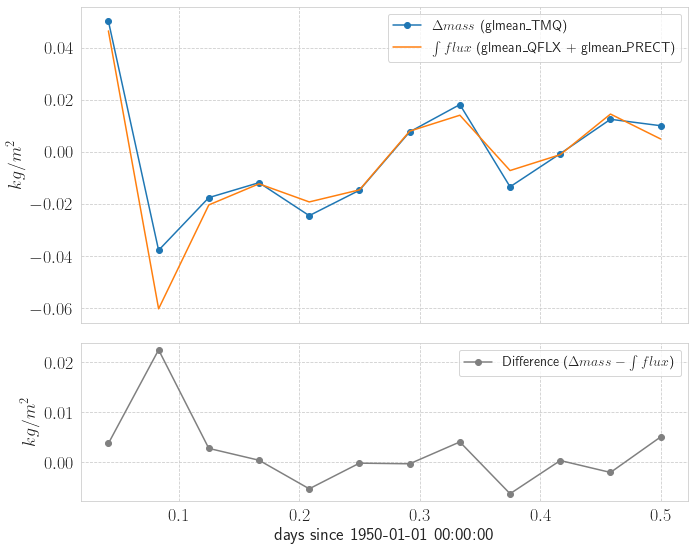

In [55]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'][1:13], arr_delta_TMQ[1:13], '-o', 
         label="$\Delta mass$" + tex_escape(' (glmean_TMQ)'))
axs[0].plot(ds['time'][1:13], arr_int_totalwaterflux[1:13], '-', 
         label="$\int flux$" + tex_escape(' (glmean_QFLX + glmean_PRECT)'))
axs[0].set_ylabel(f"$kg/m^2$")
axs[0].legend(fontsize=14)

axs[1].plot(ds['time'][1:13], arr_delta_TMQ[1:13] - arr_int_totalwaterflux[1:13], '-o', color='gray', 
         label="Difference ($\Delta mass - \int flux$)")
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2$")
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

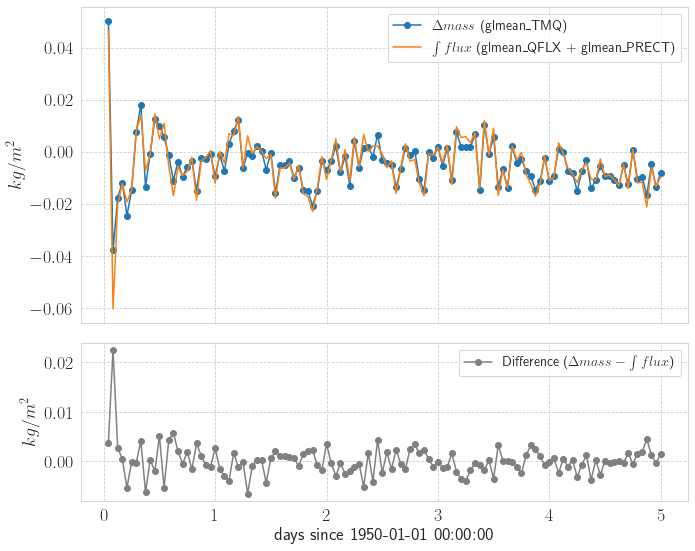

In [56]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

axs[0].plot(ds['time'][1:], arr_delta_TMQ[1:], '-o', 
         label="$\Delta mass$" + tex_escape(' (glmean_TMQ)'))
axs[0].plot(ds['time'][1:], arr_int_totalwaterflux[1:], '-', 
         label="$\int flux$" + tex_escape(' (glmean_QFLX + glmean_PRECT)'))
axs[0].set_ylabel(f"$kg/m^2$")
axs[0].legend(fontsize=14)

axs[1].plot(ds['time'][1:], arr_delta_TMQ[1:] - arr_int_totalwaterflux[1:], '-o', color='gray', 
         label="Difference ($\Delta mass - \int flux$)")
axs[1].set_xlabel(f"{ds['time'].attrs['units']}")
axs[1].set_ylabel(f"$kg/m^2$")
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [206]:
arr_delta_TMQ[1:13] - arr_int_totalwaterflux[1:13]

<xarray.DataArray (time: 12)>
array([-131.41043803, -143.73872095, -136.41218981, -150.28693543,
       -153.36098104, -161.04502332, -154.19241641, -143.37536095,
       -140.67092847, -133.68389655, -144.08388337, -144.7009975 ])
Coordinates:
  * time     (time) float64 59.0 90.0 120.0 151.0 ... 304.0 334.0 365.0 396.0